# Visualising Image Classification Models and Saliency Maps.ipynb
# test on vgg16 model

In [1]:
#import library
import numpy as np
import tensorflow as tf
import requests

from keras import backend as K
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras import Sequential
from keras.layers import Dense, Conv2D, Activation
from keras.activations import softmax, linear

from PIL import Image
from io import BytesIO

from skimage import io
from skimage import transform

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True) 

In [3]:
#load vgg16
vgg = VGG16()
vgg.summary()
filter_weights = VGG16().get_weights()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Visualize filters(weight)

normally, only first layer or second layer is worth to visaulize, since there are directly or almost directly connected to input image. They focus on the context of input image. Unlike filters in rest layers, they find context from the output of previous layer(context of context). 

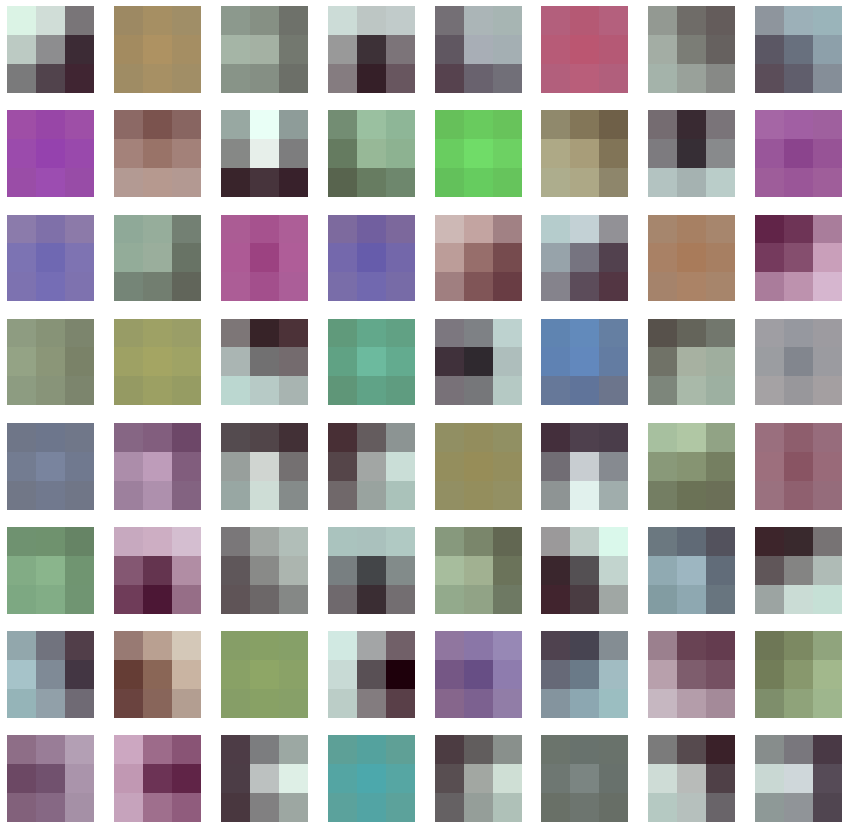

In [4]:
#preprocess filter such that pixel value in [0, 1]
#get the filter in the first layer
first_layer_filter = filter_weights[0]
filter_min, filter_max = np.min(first_layer_filter), np.max(first_layer_filter)
first_layer_filter = (first_layer_filter - filter_min)/(filter_max - filter_min)

#the output of first layer has 64 filters, plot them on 8 * 8 figure
fig, axs = plt.subplots(8, 8, figsize=(15, 15))

for i in range(8):
    for j in range(8):
        axs[i][j].imshow(first_layer_filter[:,:,:,i*8+j])
        axs[i][j].axis('off')

plt.show()

## Nearest neighbors

Use the output of last layer as feature vector, find their Top-n L2 nearest(euclidean distance) images from data set.

## Dimension reduction

use PCA or t-SNE(often use PCA to reduce to low dimensions, then use t-SNE to reduce to 2 dimensions), then draw plots...

## visualise feature map(activation)

say a feature volumn has size of (128, 8, 8). Then we visualise 128 gray scale image with size (8, 8), first few layers are good.

(<matplotlib.image.AxesImage at 0x1b24c766a48>, (224, 224, 3))

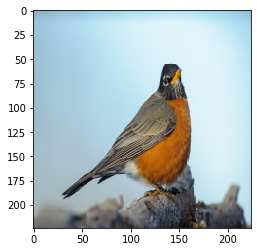

In [64]:
#use dog and bird as example
dog = 'https://farm1.static.flickr.com/104/304394105_ee88b931d8.jpg'
bird = 'https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/bird.jpg'
#resize to 224,224,3
response = requests.get(bird)
img = Image.open(BytesIO(response.content))
img_array = img_to_array(img)
img_array = transform.resize(img_array, (224, 224, 3))

#have a look the img
plt.imshow(img_array/255), img_array.shape

In [7]:
#show the activation map of first layer
get_first_act_map = Model(inputs=vgg.input, outputs=vgg.layers[1].output)

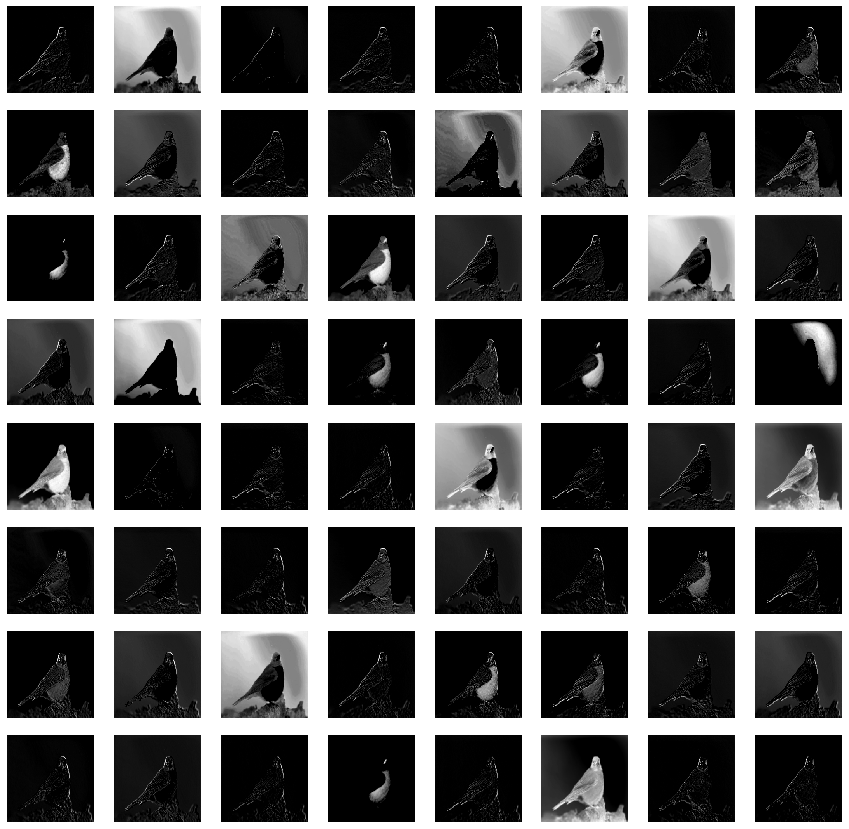

In [8]:
#swap RGB to BGR  and minus ([103.939, 116.779, 123.68]), 
# this is the mean value to each color channel(B, G, R) respectively.
# this mean value comes from IMAGENET dataset
img = preprocess_input(shepherd_dog)  
first_act_map = get_first_act_map.predict(np.expand_dims(img, axis=0))
fig, axs = plt.subplots(8, 8, figsize=(15, 15))

for i in range(8):
    for j in range(8):
        axs[i][j].imshow(first_act_map[0,:,:, i*8+j], cmap='gray')
        axs[i][j].axis('off')
        
plt.show()

## image-specific class Saliency Visualisation

useful reference: 
* https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
* https://github.com/ivanmontero/visualize-saliency/blob/master/saliency.py

generate a image that can maximize one class score

class index: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

index_hotdog: 934

Model Load

-------Show Maximum class score Image----------


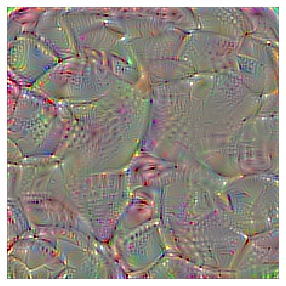

-------Show saliency map---------


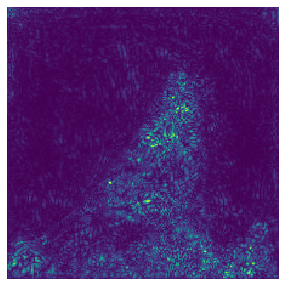

In [67]:
#how to get output before softmax:
#https://stackoverflow.com/questions/58544097/turning-off-softmax-in-tensorflow-models

#use the output before softmax
#this is because target score could increase by decrease other class score

def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def generate_img_max_class_score(model,  
                                 output_index=934, 
                                 _lambda=0.5):
    '''generate_img_max_class_score generate a image that can maximise one class score 
    
    #Arguments
        model: the model you want to visualise
        934: is a hotdog
        output_index: which class you want to visualise
        
    variable: input tensor
    loss: loss function(tensor)
    grads: gradients of loss to input image(tensor)
    initial input_img_data: 0 with shape (224, 224, 3) 
    '''
    
    #loss = max class score - l2 regularized input img
    variable = model.input
    loss = K.mean(model.output[:, output_index]) #- tf.nn.l2_loss(variable)
    grads = K.gradients(loss, variable)[0] 
    
    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([variable], [loss, grads])
    
    #make sure your input image is channel last
    input_img_data = np.random.random((1, 224, 224, 3)) * 20
    input_img_data = preprocess_img(input_img_data)
    #input_img_data = np.zeros((1, 224, 224, 3), dtype='float64')
    #input_img_data = np.expand_dims(img_array, axis=0)
    
    #print(f'input_img_data: {input_img_data[0,:,:,0]}')
    #print()
    
    #feed forward 55 times
    for i in range(128):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value[0]
        #print(f'This is {i}\'th loop,\n grads_value is {grads_value[0]}')
        #print()
    
    return input_img_data

def preprocess_img(img):
    
    mean = [103.939, 116.779, 123.68]
    img += mean

    return img

def deprocess_img(img):
    '''
    #assume input img use 'caffe' preprocess
    #that is convert RGB to BGR, then each color channel minus mean from ImageNet
    
    '''
    #img = (img-np.min(img, axis=(0, 1))) / (np.max(img, axis=(0, 1)) - np.min(img, axis=(0, 1)))
    
    # normalize tensor: center on 0., ensure std is 0.1
    #mean = np.array([103.939, 116.779, 123.68])
    #std = np.array([58.395, 57.12 , 57.375])
    img = img[:,:,::-1]
    
    img -= img.mean()
    img /= (img.std() + 1e-5)
    
    img *= 0.1

    # clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype('uint8')
    
    return img

def show_maximum_img(model):
    #feed input image
    img = generate_img_max_class_score(model, output_index)[0]
    img = deprocess_img(img)  

    #show image
    
    fig, ax= plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.axis('off')
    plt.show()

def show_saliency_map(model, img):
    '''
    #Arguments:
        model: model use to visualise
        img: image to show saliency map
    '''
    
    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients(loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    img = np.expand_dims(img, axis=0)
    w, loss_value = func(img)
    M = np.max(np.absolute(w[0][0]), axis=2)
     
    #show image
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(M)
    ax.axis('off')
    plt.show()
    
if __name__ == '__main__':
    '''
    output_index: class you want to visualise
    500 is soccer
    '''
    
    output_index = 805
    get_unnormed_output = unnormed_output_model(vgg)
    
    print('Model Load')
    print()
    
    #show maximum_class_score_img
    print('-------Show Maximum class score Image----------')
    show_maximum_img(get_unnormed_output)

    #show saliency_map
    #use preloaded bird image  
    print('-------Show saliency map---------')
    show_saliency_map(get_unnormed_output, img_array)